# Проект III

## Оценка доступности школ и детских садов


#### **Цель:**

Проанализировать доступность детских общеобразовательных учреждений для выбранного гордского района. Для этого необходимо посчитать количество человек и долю от всего населения, кто проживает в зоне доступности от детских общеобразовательных учреждений (школ - 500 метров, детских садов - 300 метров). Предлагаем взять любой район Москвы или Санкт-Петербурга\*.

\*_Примечание: вы можете выполнять задание и для других городов, но в таком случае необходимо самостоятельно найти и подготовить данные для оценки численности населения._

**Требуется определить:**

1. Количество человек в зоне доступности и школ, и детских садов.
2. Количество человек в зоне доступности только школ.
3. Количество человек в зоне доступности только детских садов.
4. Количество человек за пределами зон доступности общеобразовательных учреждений.

#### **Данные:**

1. Для оценки численности населения: `msk_mkd.csv` (Москва) или `spb_mkd.csv` (Санкт-Петербург).
2. Границы административных районов: можете экспортировать из OpenStreetMap.
3. Данные о местоположении школ и детских садов: можно экспортировать из OSM или использовать порталы открытых данных [Москвы](https://data.mos.ru/) или [Санкт-Петербурга](https://data.gov.spb.ru/).

#### **Требования к итоговому результату:**

Результаты представить в виде:

- Графика распределения количества людей по указанным категориям.
- Карты, на которой будет видно, в какую из категорий попадает каждое здание.
- Небольшого описания полученных результатов (оценить, насколько хорошая доступность в районе и по каким причинам).

##### **Формат сдачи задания:**

- Файл Jupyter Notebook (`.ipynb`), содержащий весь выполненный анализ, комментарии к коду и результаты.
- Если Вы работали с Москвой или Санкт-Петербургом, то никаких дополнительных данных или документов прилагать не нужно: все исходники (CSV/GPKG) уже заданы в условии. Для других городов - приложите используемые данные

##### **Критерии оценивания (max. 10 баллов):**

- **2 балла** – Загрузка и первичная проверка данных
- **2 балла** – Получение и подготовка данных об образовательных учреждениях
- **2 балла** – Классификация зданий и агрегация численности населения (корректно подсчитана суммарная численность людей в каждой категории)
- **2 балла** – Визуализация результатов
- **2 балла** – Выводы и оформление


##### **Шаги работы**


### Шаг 0. Импортируйте нужные библиотеки


In [1]:
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import networkx as nx
import osmnx as ox
import pandas as pd

warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:.2f}".format

### Шаг 1. Подготовка данных


**Шаг 1.1. Загрузка данных о населении**

- Загрузите CSV-файл (`msk_mkd.csv` или `spb_mkd.csv`) с данными о многоквартирных домах и численности населения.
- Проверьте систему координат. Если необходимо, преобразуйте.


In [2]:
raw_pop = pd.read_csv("msk_mkd.csv")
raw_pop = raw_pop.dropna(subset=["lat", "lon", "DistrictPop"])

population_gdf = gpd.GeoDataFrame(
    raw_pop,
    geometry=gpd.points_from_xy(raw_pop["lon"], raw_pop["lat"]),
    crs="EPSG:4326",
)
population_gdf = population_gdf[population_gdf["DistrictPop"] > 0].copy()
population_gdf.head()

,fid,field_1,formalname_region,address,houseguid,management_organization_id,built_year,exploitation_start_year,project_type,house_type,...,sewerage_cesspools_volume,gas_type,ventilation_type,firefighting_type,drainage_type,lat,lon,DistrictName,DistrictPop,geometry
0,1,1,Москва,"г. Москва, д. 9, к. 1",521474b9-1d5a-702f-3b75-33ff10263733,7628409.00,1973.00,1973.00,П-49-04/70Д,Многоквартирный дом,...,0.00,Центральное,Вытяжная вентиляция,Отсутствует,Внутренние водостоки,55.76,37.62,Тверской район,77123.00,POINT (37.61764 55.75581)
1,2,2,Москва,"г. Москва, д. 42, к. 2",4b9cbbad-b371-6ce1-bebe-09e785d0b894,NaN,1985.00,1985.00,П-44,Многоквартирный дом,...,NaN,Отсутствует,Приточно-вытяжная вентиляция,Пожарные гидранты,Внутренние водостоки,55.76,37.62,Тверской район,77123.00,POINT (37.61764 55.75581)
2,3,3,Москва,"г. Москва, ул. 10-летия Октября, д. 9",723e2dcf-d203-4dc1-89de-9b41f453916a,8916986.00,1900.00,1900.00,индивидуальный проект,Многоквартирный дом,...,0.00,Центральное,Приточно-вытяжная вентиляция,Пожарные гидранты,Наружные водостоки,55.73,37.56,район Хамовники,107676.00,POINT (37.56312 55.72548)
3,4,4,Москва,"г. Москва, ул. 1812 года, д. 1",8425ff55-ec42-466a-a993-de4e5faaba3b,8250803.00,1957.00,1957.00,индивидуальный проект,Многоквартирный дом,...,NaN,Центральное,Приточно-вытяжная вентиляция,Пожарные гидранты,Внутренние водостоки,55.73,37.52,район Дорогомилово,71964.00,POINT (37.52351 55.73463)
4,5,5,Москва,"г. Москва, ул. 1812 года, д. 2",a8ad9e0b-e0c1-46a7-981c-4d5a598c76ce,8250803.00,1954.00,1954.00,индивидуальный проект,Многоквартирный дом,...,NaN,Центральное,Приточно-вытяжная вентиляция,Пожарные гидранты,Внутренние водостоки,55.74,37.53,район Дорогомилово,71964.00,POINT (37.52503 55.73581)


In [3]:
# Группируем данные по району и считаем суммарную площадь жилых помещений
# и среднюю обеспеченность жилой площадью на одного жителя в районе
district_stat = population_gdf.groupby('DistrictName').agg(
    total_residential_area=('area_residential', 'sum')
).reset_index()

# Объединяем эти данные с исходным DataFrame population_gdf по полю 'DistrictName'
population_gdf = population_gdf.merge(district_stat[['DistrictName', 'total_residential_area']], on='DistrictName', how='inner')

# Считаем обеспеченность
population_gdf['avg_area_per_person'] = population_gdf['total_residential_area'] / population_gdf['DistrictPop']

# Оцениваем кол-во человек на основе обеспеченности
population_gdf['estimated_population'] = population_gdf['area_residential'] / population_gdf['avg_area_per_person']

# Смотрим на результат
population_gdf.head()

,fid,field_1,formalname_region,address,houseguid,management_organization_id,built_year,exploitation_start_year,project_type,house_type,...,firefighting_type,drainage_type,lat,lon,DistrictName,DistrictPop,geometry,total_residential_area,avg_area_per_person,estimated_population
0,1,1,Москва,"г. Москва, д. 9, к. 1",521474b9-1d5a-702f-3b75-33ff10263733,7628409.00,1973.00,1973.00,П-49-04/70Д,Многоквартирный дом,...,Отсутствует,Внутренние водостоки,55.76,37.62,Тверской район,77123.00,POINT (37.61764 55.75581),2016937.82,26.15,188.89
1,2,2,Москва,"г. Москва, д. 42, к. 2",4b9cbbad-b371-6ce1-bebe-09e785d0b894,NaN,1985.00,1985.00,П-44,Многоквартирный дом,...,Пожарные гидранты,Внутренние водостоки,55.76,37.62,Тверской район,77123.00,POINT (37.61764 55.75581),2016937.82,26.15,992.00
2,3,3,Москва,"г. Москва, ул. 10-летия Октября, д. 9",723e2dcf-d203-4dc1-89de-9b41f453916a,8916986.00,1900.00,1900.00,индивидуальный проект,Многоквартирный дом,...,Пожарные гидранты,Наружные водостоки,55.73,37.56,район Хамовники,107676.00,POINT (37.56312 55.72548),2649986.33,24.61,47.58
3,4,4,Москва,"г. Москва, ул. 1812 года, д. 1",8425ff55-ec42-466a-a993-de4e5faaba3b,8250803.00,1957.00,1957.00,индивидуальный проект,Многоквартирный дом,...,Пожарные гидранты,Внутренние водостоки,55.73,37.52,район Дорогомилово,71964.00,POINT (37.52351 55.73463),1476280.96,20.51,811.59
4,5,5,Москва,"г. Москва, ул. 1812 года, д. 2",a8ad9e0b-e0c1-46a7-981c-4d5a598c76ce,8250803.00,1954.00,1954.00,индивидуальный проект,Многоквартирный дом,...,Пожарные гидранты,Внутренние водостоки,55.74,37.53,район Дорогомилово,71964.00,POINT (37.52503 55.73581),1476280.96,20.51,1040.35


**Шаг 1.2. Загрузка границ административных районов**

- Загрузите административные границы города (например, из OSM)
- Выберите интересующий вас район города (в Москве или Санкт-Петербурге).
- Отфильтруйте GeoDataFrame по названию выбранного района.


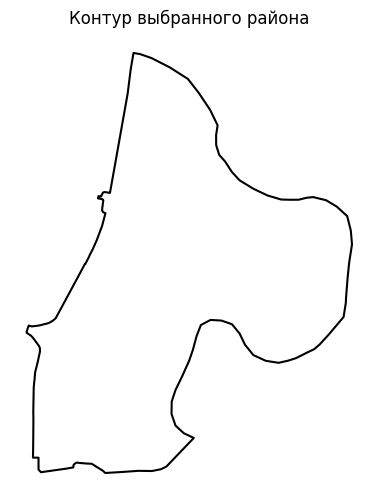

In [4]:
district_query = "район Строгино, Москва, Россия"
district_boundary = ox.geocode_to_gdf(district_query).to_crs(population_gdf.crs)
district_polygon = district_boundary.geometry.iloc[0]

# display(district_boundary[["display_name", "geometry"]])

fig, ax = plt.subplots(figsize=(6, 6))
district_boundary.boundary.plot(ax=ax, color="black")
ax.set_title("Контур выбранного района")
ax.set_axis_off()
plt.show()


**Шаг 1.3. Обрезка данных по границам района**

- Обрежьте GeoDataFrame с населением по границам выбранного района.


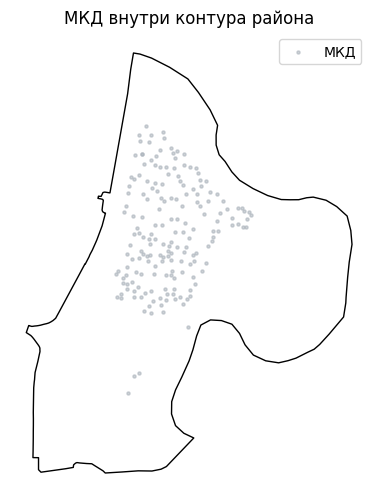

In [5]:
population_district = gpd.clip(population_gdf, district_boundary).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(6, 6))
district_boundary.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)
population_district.plot(ax=ax, color="#adb5bd", markersize=5, alpha=0.6, label="МКД")
ax.set_title("МКД внутри контура района")
ax.set_axis_off()
ax.legend(loc="upper right")
plt.show()

### Шаг 2. Получение данных об образовательных учреждениях


**Шаг 2.1. Экспорт данных из OpenStreetMap или открытых источников**

- Получите данные о местоположении школ и детских садов.
- Можно использовать библиотеку `OSMNx` для загрузки данных из OSM по тэгам `amenity=school` и `amenity=kindergarten`.
- Для данных OSM - отфильтруйте на основе типа геометрии
- Проверьте и точки и полигоны - какая информация наиболее полная?
- Для удобства последующих расчётов можно использовать центроиды полигонов


Количество школ в районе: 21
Количество детских садов в районе: 30


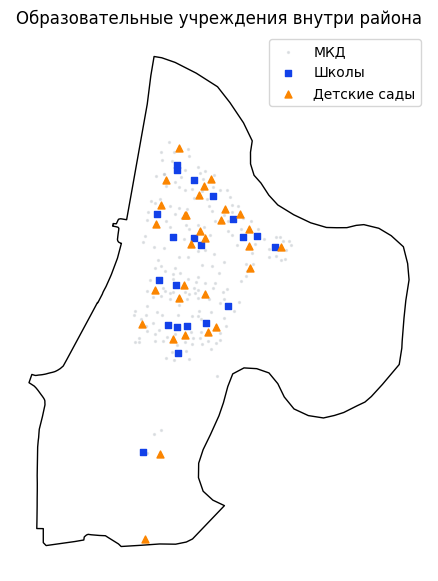

In [6]:
def load_osm_pois(amenity_tag: str) -> gpd.GeoDataFrame:
    """Загружаем объекты OSM и приводим их к точкам внутри выбранного контура."""
    pois = ox.features_from_polygon(district_polygon, tags={"amenity": amenity_tag})

    pois = pois.to_crs(population_district.crs)
    pois = pois[pois.geometry.notnull() & (~pois.geometry.is_empty)].copy()
    pois["geometry"] = pois.geometry.apply(
        lambda geom: geom if geom.geom_type == "Point" else geom.centroid
    )
    pois = pois.drop_duplicates(subset="geometry").reset_index(drop=True)
    return pois[["geometry"]]

schools_gdf = load_osm_pois("school")
kindergartens_gdf = load_osm_pois("kindergarten")

print(f"Количество школ в районе: {len(schools_gdf)}")
print(f"Количество детских садов в районе: {len(kindergartens_gdf)}")

fig, ax = plt.subplots(figsize=(7, 7))
district_boundary.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)
population_district.plot(ax=ax, markersize=2, alpha=0.3, color="#adb5bd", label="МКД")
schools_gdf.plot(ax=ax, markersize=25, color="#1241E9", label="Школы", marker="s")
kindergartens_gdf.plot(ax=ax, markersize=25, color="#fb8500", label="Детские сады", marker="^")
ax.set_title("Образовательные учреждения внутри района")
ax.set_axis_off()
ax.legend(loc="upper right")
plt.show()


### Шаг 3. Создание зон доступности


В данном задании есть два пути на Ваш выбор: можно определить зону доступности с помощью буферов или с использованием инструментов сетевого анализа


**Шаг 3.1. Определение зон доступности**

- Постройте вокруг точек школ зоны доступности с радиусом 500 метров.
- Постройте вокруг точек детских садов зоны доступности с радиусом 300 метров.

!Зоны доступности необходимо рассчитывать на основе улично-дорожной сети!


In [7]:
# Логика построения графа: собираем УДС через osmnx и
# строим метрический граф для дальнейших изохрон через networkx.
walk_graph = ox.graph_from_polygon(district_polygon, network_type="walk", simplify=True)
walk_graph_proj = ox.project_graph(walk_graph)
graph_crs = walk_graph_proj.graph["crs"]

population_district_proj = population_district.to_crs(graph_crs)
district_boundary_proj = district_boundary.to_crs(graph_crs)
schools_proj = schools_gdf.to_crs(graph_crs)
kindergartens_proj = kindergartens_gdf.to_crs(graph_crs)

nodes_proj, edges_proj = ox.graph_to_gdfs(walk_graph_proj)
edges_proj = edges_proj.reset_index()

print(
    f"Граф: {len(nodes_proj)} узлов и {len(edges_proj)} ребер; CRS: {graph_crs}"
)

Граф: 3188 узлов и 9208 ребер; CRS: EPSG:32637


**Шаг 3.2. Объединение в единую зону**

- Объедините все зоны для школ в один полигон (union).
- Объедините все зоны детских садов в один полигон.


In [8]:
SCHOOL_RADIUS = 500  # м
KINDER_RADIUS = 300  # м


def compute_service_area(
    graph_proj: nx.Graph,
    edges: gpd.GeoDataFrame,
    pois: gpd.GeoDataFrame,
    radius_m: int,
) -> tuple[dict[int, float], gpd.GeoSeries | None]:
    """Строим изохрону через nx.ego_graph/multi-source Dijkstra."""

    facility_nodes = ox.distance.nearest_nodes(
        graph_proj,
        X=pois.geometry.x,
        Y=pois.geometry.y,
    )
    facility_nodes = list(set(facility_nodes))

    reachable_lengths = nx.multi_source_dijkstra_path_length(
        graph_proj,
        facility_nodes,
        cutoff=radius_m,
        weight="length",
    )
    reachable_nodes = set(reachable_lengths.keys())

    sub_edges = edges[
        edges["u"].isin(reachable_nodes) & edges["v"].isin(reachable_nodes)
    ]

    zone_geom = sub_edges.geometry.unary_union.buffer(30)
    clipped_zone = zone_geom.intersection(district_boundary_proj.geometry.iloc[0])
    return reachable_lengths, gpd.GeoSeries([clipped_zone], crs=graph_crs)


school_lengths, school_zone = compute_service_area(
    walk_graph_proj, edges_proj, schools_proj, SCHOOL_RADIUS
)
kinder_lengths, kinder_zone = compute_service_area(
    walk_graph_proj, edges_proj, kindergartens_proj, KINDER_RADIUS
)

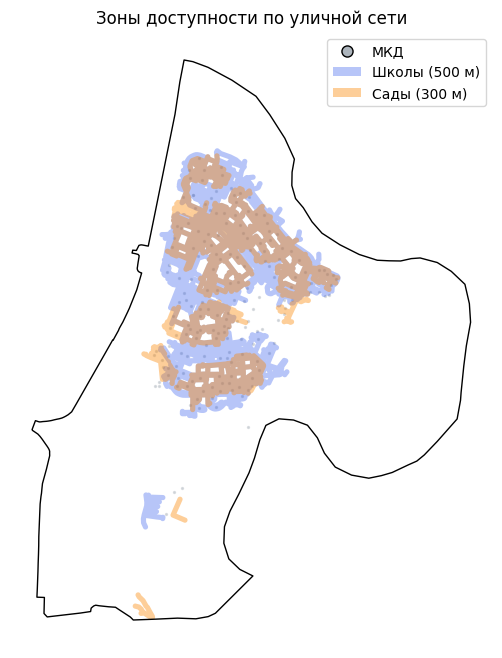

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))
district_boundary_proj.boundary.plot(ax=ax, color="black", linewidth=1)
population_district_proj.plot(ax=ax, markersize=2, color="#adb5bd", alpha=0.4)
school_zone.plot(ax=ax, color="#1241E9", alpha=0.3)
kinder_zone.plot(ax=ax, color="#fb8500", alpha=0.4)

ax.set_title("Зоны доступности по уличной сети")
ax.set_axis_off()

# --- создаём кастомную легенду ---
legend_elements = [
    Line2D([0], [0], marker='o', color='none', label='МКД',
           markerfacecolor='#adb5bd', markersize=8),
    Patch(facecolor='#1241E9', edgecolor='none', alpha=0.3, label='Школы (500 м)'),
    Patch(facecolor='#fb8500', edgecolor='none', alpha=0.4, label='Сады (300 м)')
]

ax.legend(handles=legend_elements, loc="upper right")

plt.show()

### Шаг 4. Классификация зданий по категориям доступности


**Шаг 4.1. Определение принадлежности к зонам**

- Для каждого многоквартирного дома (МКД) определите, попадает ли он в зону школ, в зону детских садов, в обе зоны или не попадает ни в одну.


In [10]:
population_district_proj["nearest_node"] = ox.distance.nearest_nodes(
    walk_graph_proj,
    X=population_district_proj.geometry.x,
    Y=population_district_proj.geometry.y,
)

population_district_proj["dist_school"] = population_district_proj["nearest_node"].map(school_lengths)
population_district_proj["dist_kinder"] = population_district_proj["nearest_node"].map(kinder_lengths)

population_district_proj["in_school"] = population_district_proj["dist_school"].notna()
population_district_proj["in_kinder"] = population_district_proj["dist_kinder"].notna()

population_district_proj[[
    "nearest_node",
    "dist_school",
    "dist_kinder",
    "in_school",
    "in_kinder",
]].head()


,nearest_node,dist_school,dist_kinder,in_school,in_kinder
0,430405255,NaN,NaN,False,False
1,5777491574,166.30,NaN,True,False
2,5777491605,159.82,NaN,True,False
3,2620456507,417.14,NaN,True,False
4,305168556,73.74,70.65,True,True


**Шаг 4.2. Агрегация численности населения по категориям**

- Рассчитайте суммарную численность населения для каждой категории:
  1. В зоне и школ, и детских садов.
  2. В зоне только школ.
  3. В зоне только детских садов.
  4. За пределами зон доступности.


In [11]:
category_map = {
    (True, True): "Школа и сад",
    (True, False): "Только школа",
    (False, True): "Только сад",
    (False, False): "Нет доступа",
}

population_district_proj["access_category"] = population_district_proj.apply(
    lambda row: category_map[(row["in_school"], row["in_kinder"])], axis=1
)

category_order = [
    "Школа и сад",
    "Только школа",
    "Только сад",
    "Нет доступа",
]

pop_counts = (
    population_district_proj.groupby("access_category")["estimated_population"].sum()
    .reindex(category_order, fill_value=0)
)

category_stats = pd.DataFrame(
    {
        "population": pop_counts,
        "share_%": (pop_counts / pop_counts.sum() * 100).round(1),
    }
)
category_stats


,population,share_%
access_category,,
Школа и сад,83769.10,52.80
Только школа,58426.56,36.80
Только сад,6141.24,3.90
Нет доступа,10465.10,6.60


### Шаг 5. Визуализация результатов


**Шаг 5.1. Построение графика распределения численности населения**

- Постройте график показывающий количество человек


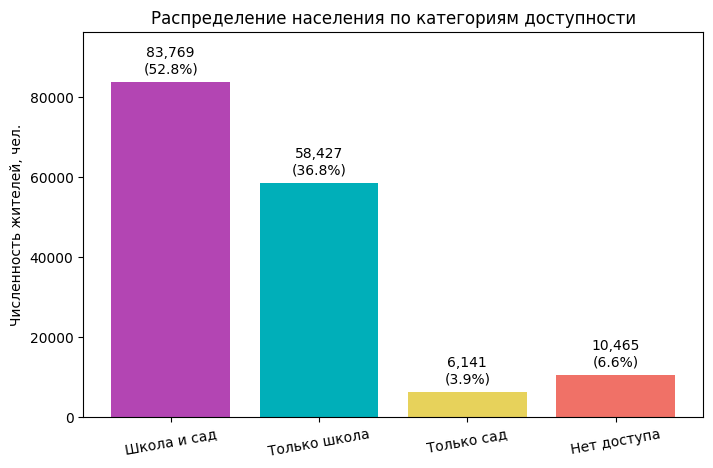

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(pop_counts.index, pop_counts.values, color=["#b345b3", "#00afb9", "#e7d25b", "#f07167"])

total_population = pop_counts.sum()
for bar, value in zip(bars, pop_counts.values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + total_population * 0.01,
        f"{value:,.0f}\n({value / total_population:.1%})",
        ha="center",
        va="bottom",
        fontsize=10,
    )

ax.set_ylabel("Численность жителей, чел.")
ax.set_title("Распределение населения по категориям доступности")
ax.set_ylim(0, max(pop_counts.values) * 1.15)
plt.xticks(rotation=10)
plt.show()

**Шаг 5.2. Построение карты с категориями зданий**

- Создайте карту (в любом известном вам формате), где здания будут раскрашены в зависимости от категории доступности


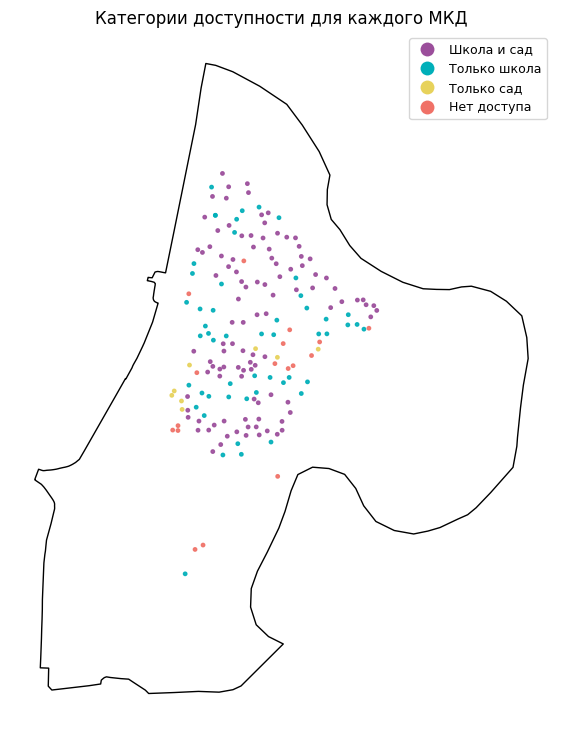

In [13]:
access_palette = {
    "Школа и сад": "#9b4e9b",
    "Только школа": "#00afb9",
    "Только сад": "#e7d25b",
    "Нет доступа": "#f07167",
}

# --- кастомные элементы легенды ---
legend_elements = [
    Line2D([0], [0], marker='o', linestyle='',
           markerfacecolor=color, markeredgecolor='none',
           markersize=10, label=label)
    for label, color in access_palette.items()
]

fig, ax = plt.subplots(figsize=(9, 9))
population_district_proj.plot(
    ax=ax,
    # column="access_category",
    categorical=True,
    legend=True,
    cmap=None,
    color=population_district_proj["access_category"].map(access_palette),
    alpha=0.9,
    markersize=6,
)

district_boundary_proj.boundary.plot(ax=ax, color="black", linewidth=1)
ax.set_title("Категории доступности для каждого МКД")
ax.set_axis_off()
# --- добавляем легенду ---
ax.legend(handles=legend_elements, loc="upper right", fontsize=9)

plt.show()

### Шаг 6. Описание результатов


- Проанализируйте полученные данные.
- Оцените, насколько хорошая доступность образовательных учреждений в выбранном районе.
- Опишите возможные причины наблюдаемой ситуации (например, густота застройки, удаленность учреждений и т.д.).


По полученным данным можно сделать вывод, что в Строгино **очень хорошая доступность** образовательных учреждений, так как более чем у **90%** жителей района есть школа или детский сад в шаговой доступности.  
Причину наблюдаемой ситуации мы видим на карте: застройка в районе **достаточно густая**, учреждения **удобно расположены** и сосредотачивают вокруг себя **много домов**